In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Concatenate, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.regularizers import l1_l2
import plotly.express as px


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive'  # take a look at the Google Drive content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
MyDrive


## 1. Importing and Exploring Data

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Deep Learning Project 2022/Data/chest_xray/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5232 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Deep Learning Project 2022/Data/chest_xray/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 624 images belonging to 2 classes.


In [ ]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#2.Callbacks

In [ ]:
filepath = './best_weights.hdf5'


earlystopping = EarlyStopping(monitor = 'val_acc', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]


## 3. CNN1 - basic model

In [ ]:
# Initialising the CNN
classifier1 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier1.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Flatten())

classifier1.add(Dense(units = 128, activation = 'relu'))
classifier1.add(Dense(units = 1, activation = 'sigmoid'))



In [ ]:
classifier1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [ ]:
classifier1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist1=classifier1.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.1926 - acc: 0.9234
Epoch 1: val_acc improved from -inf to 0.93269, saving model to ./best_weights.hdf5
164/164 [==============================] - 102s 620ms/step - loss: 0.1926 - acc: 0.9234 - val_loss: 0.1763 - val_acc: 0.9327
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.1767 - acc: 0.9299
Epoch 2: val_acc did not improve from 0.93269
164/164 [==============================] - 107s 652ms/step - loss: 0.1767 - acc: 0.9299 - val_loss: 0.4771 - val_acc: 0.7997
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.1592 - acc: 0.9381
Epoch 3: val_acc did not improve from 0.93269
164/164 [==============================] - 104s 637ms/step - loss: 0.1592 - acc: 0.9381 - val_loss: 0.3613 - val_acc: 0.8638
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.1579 - acc: 0.9404
Epoch 4: val_acc improved from 0.93269 to 0.93750, saving model to ./best_weights.hdf

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = classifier1.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[195  39]
 [  5 385]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.97      0.83      0.90       234
   PNEUMONIA       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
acc = hist1.history['acc']
val_acc = hist1.history['val_acc']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

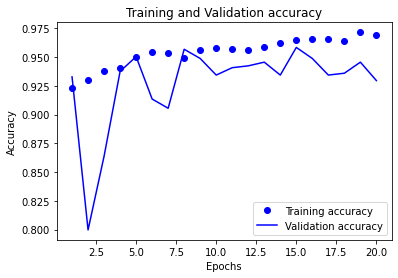

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

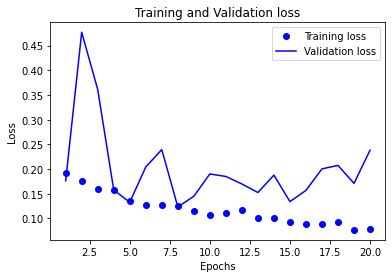

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. CNN2 - with Dropout

In [ ]:
# Initialising the CNN
classifier2 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier2.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Flatten())

classifier2.add(Dense(units = 128, activation = 'relu'))
classifier2.add(Dropout(rate=0.5))
classifier2.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 37, 37, 64)       

In [ ]:
classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist2=classifier2.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.4789 - acc: 0.7943
Epoch 1: val_acc did not improve from 0.95833
164/164 [==============================] - 102s 619ms/step - loss: 0.4789 - acc: 0.7943 - val_loss: 0.3982 - val_acc: 0.8317
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.2930 - acc: 0.8735
Epoch 2: val_acc did not improve from 0.95833
164/164 [==============================] - 100s 608ms/step - loss: 0.2930 - acc: 0.8735 - val_loss: 0.2824 - val_acc: 0.8910
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.2513 - acc: 0.8964
Epoch 3: val_acc did not improve from 0.95833
164/164 [==============================] - 101s 615ms/step - loss: 0.2513 - acc: 0.8964 - val_loss: 0.2918 - val_acc: 0.8894
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.2447 - acc: 0.8989
Epoch 4: val_acc did not improve from 0.95833
164/164 [==============================] - 100s 608ms/step - loss: 0.2447 - a

In [ ]:
Y_pred = classifier2.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[164  70]
 [  6 384]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.96      0.70      0.81       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [ ]:
acc = hist2.history['acc']
val_acc = hist2.history['val_acc']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

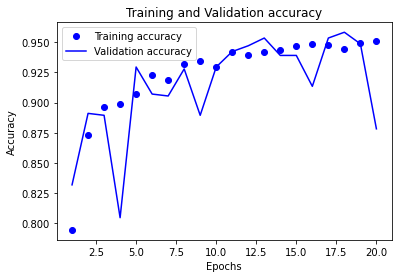

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

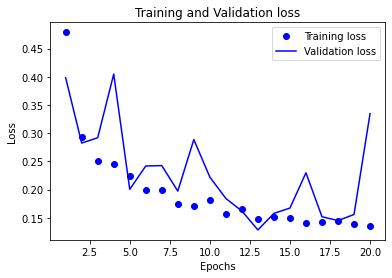

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. CNN3 - with Dropout and BatchNormalization


Similar to cnn_2, but with BatchNormalization.
Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural 
network, and in some cases improves the performance of the model via a modest regularization effect.

In [ ]:
# Initialising the CNN
classifier3 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier3.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Flatten())

classifier3.add(Dense(units = 128, activation = 'relu'))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.5))
classifier3.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 74, 74, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 64)      

In [ ]:
classifier3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist3=classifier3.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.3575 - acc: 0.8670
Epoch 1: val_acc did not improve from 0.95833
164/164 [==============================] - 103s 617ms/step - loss: 0.3575 - acc: 0.8670 - val_loss: 2.0608 - val_acc: 0.6250
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.2035 - acc: 0.9287
Epoch 2: val_acc did not improve from 0.95833
164/164 [==============================] - 101s 616ms/step - loss: 0.2035 - acc: 0.9287 - val_loss: 0.4823 - val_acc: 0.7772
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.1764 - acc: 0.9377
Epoch 3: val_acc did not improve from 0.95833
164/164 [==============================] - 101s 618ms/step - loss: 0.1764 - acc: 0.9377 - val_loss: 0.3987 - val_acc: 0.8269
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.1571 - acc: 0.9451
Epoch 4: val_acc did not improve from 0.95833
164/164 [==============================] - 101s 618ms/step - loss: 0.1571 - a

In [ ]:
Y_pred = classifier3.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[233   1]
 [282 108]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.45      1.00      0.62       234
   PNEUMONIA       0.99      0.28      0.43       390

    accuracy                           0.55       624
   macro avg       0.72      0.64      0.53       624
weighted avg       0.79      0.55      0.50       624



In [ ]:
acc = hist3.history['acc']
val_acc = hist3.history['val_acc']
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

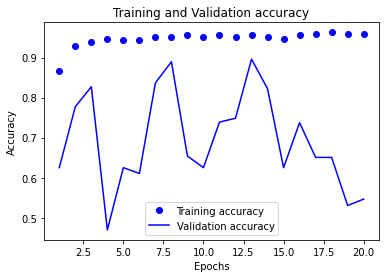

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

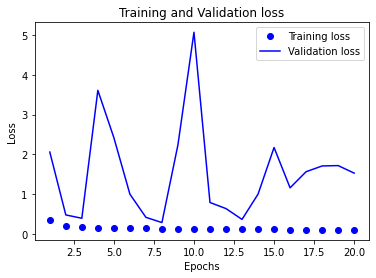

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. CNN4 - with Dropout, BatchNormalization and two conv layers in a row.

This is something possible and commonly used in very challenging tasks.
The idea of having two (or more) conv layers is to perform a more in-depth analysis of local patterns of the image.
There is no rule for deciding if two consecutive conv layers are better than a conv layer followed by a pooling layer.

In [ ]:
# Initialising the CNN
classifier4 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier4.add(Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier4.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
classifier4.add(Conv2D(64, (3, 3), padding='same'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Flatten())

classifier4.add(Dense(units = 128, activation = 'relu'))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.5))
classifier4.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 73, 73, 32)        9

In [ ]:
classifier4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist4=classifier4.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.3529 - acc: 0.8656 
Epoch 1: val_acc improved from -inf to 0.62500, saving model to ./best_weights.hdf5
164/164 [==============================] - 2060s 12s/step - loss: 0.3529 - acc: 0.8656 - val_loss: 2.1370 - val_acc: 0.6250
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.2206 - acc: 0.9193
Epoch 2: val_acc did not improve from 0.62500
164/164 [==============================] - 109s 668ms/step - loss: 0.2206 - acc: 0.9193 - val_loss: 1.8503 - val_acc: 0.6250
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.1864 - acc: 0.9310
Epoch 3: val_acc did not improve from 0.62500
164/164 [==============================] - 108s 656ms/step - loss: 0.1864 - acc: 0.9310 - val_loss: 3.3535 - val_acc: 0.6250
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.1777 - acc: 0.9318
Epoch 4: val_acc did not improve from 0.62500
164/164 [==============================

In [ ]:
Y_pred = classifier4.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 15 219]
 [  0 390]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      0.06      0.12       234
   PNEUMONIA       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.82      0.53      0.45       624
weighted avg       0.78      0.65      0.53       624



In [ ]:
acc = hist4.history['acc']
val_acc = hist4.history['val_acc']
loss = hist4.history['loss']
val_loss = hist4.history['val_loss']

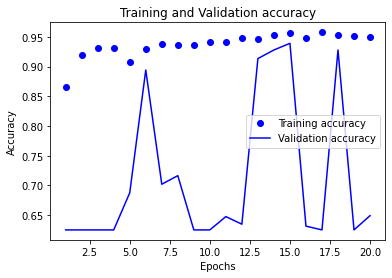

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

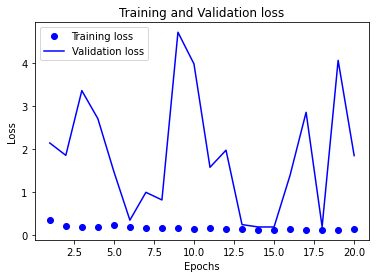

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. CNN5 - Same as CNN4, but with regularizers (L1 and L2).

In [ ]:
# Initialising the CNN
classifier5 = Sequential()

In [ ]:
l1_cnn_5 = 0.001
l2_cnn_5 = 0.001

In [ ]:
# Step 1 - Convolution
classifier5.add(Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Flatten())

classifier5.add(Dense(units = 128, activation = 'relu'))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.5))
classifier5.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 73, 73, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 73, 73, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 73, 73, 32)       

In [ ]:
classifier5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist5=classifier.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 1.5873 - acc: 0.8811
Epoch 1: val_acc did not improve from 0.93910
164/164 [==============================] - 112s 671ms/step - loss: 1.5873 - acc: 0.8811 - val_loss: 2.6882 - val_acc: 0.6250
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.9512 - acc: 0.9111
Epoch 2: val_acc did not improve from 0.93910
164/164 [==============================] - 108s 659ms/step - loss: 0.9512 - acc: 0.9111 - val_loss: 3.3366 - val_acc: 0.6250
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.6486 - acc: 0.9243
Epoch 3: val_acc did not improve from 0.93910
164/164 [==============================] - 109s 663ms/step - loss: 0.6486 - acc: 0.9243 - val_loss: 1.9593 - val_acc: 0.6250
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.4775 - acc: 0.9228
Epoch 4: val_acc did not improve from 0.93910
164/164 [==============================] - 108s 655ms/step - loss: 0.4775 - a

In [ ]:
Y_pred = classifier5.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 65 169]
 [  0 390]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      0.28      0.43       234
   PNEUMONIA       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.64      0.63       624
weighted avg       0.81      0.73      0.68       624



In [ ]:
acc = hist5.history['acc']
val_acc = hist5.history['val_acc']
loss = hist5.history['loss']
val_loss = hist5.history['val_loss']

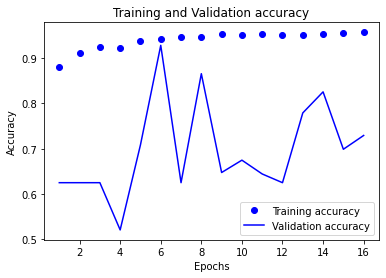

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

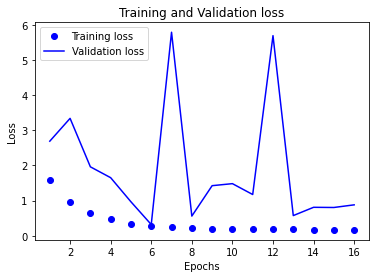

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. CNN6 - Similar to cnn1, but with 256 units in the fully-connected layer, and 64 batches in the fit.


In [ ]:
# Initialising the CNN
classifier6 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier6.add(Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Flatten())

classifier6.add(Dense(units = 256, activation = 'relu'))
classifier6.add(Dense(units = 1, activation = 'sigmoid'))


In [ ]:
classifier6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 74, 74, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 37, 37, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 256)     

In [ ]:
classifier6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist6=classifier6.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.4134 - acc: 0.8337
Epoch 1: val_acc did not improve from 0.93910
164/164 [==============================] - 111s 666ms/step - loss: 0.4134 - acc: 0.8337 - val_loss: 0.3401 - val_acc: 0.8526
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.2280 - acc: 0.9084
Epoch 2: val_acc did not improve from 0.93910
164/164 [==============================] - 108s 655ms/step - loss: 0.2280 - acc: 0.9084 - val_loss: 0.3143 - val_acc: 0.8686
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.2028 - acc: 0.9190
Epoch 3: val_acc did not improve from 0.93910
164/164 [==============================] - 107s 651ms/step - loss: 0.2028 - acc: 0.9190 - val_loss: 0.2880 - val_acc: 0.8958
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.1696 - acc: 0.9329
Epoch 4: val_acc did not improve from 0.93910
164/164 [==============================] - 108s 657ms/step - loss: 0.1696 - a

In [ ]:
Y_pred = classifier6.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[218  16]
 [  9 381]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.96      0.93      0.95       234
   PNEUMONIA       0.96      0.98      0.97       390

    accuracy                           0.96       624
   macro avg       0.96      0.95      0.96       624
weighted avg       0.96      0.96      0.96       624



In [ ]:
acc = hist6.history['acc']
val_acc = hist6.history['val_acc']
loss = hist6.history['loss']
val_loss = hist6.history['val_loss']

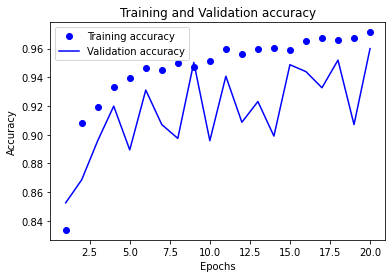

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

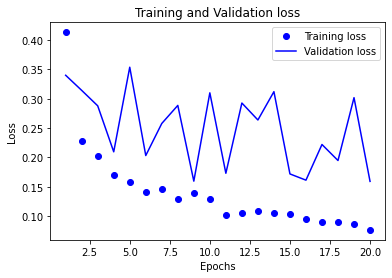

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()